In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt


import sys
sys.path.append("../../")
from Environment import SpringMass
from Subroutines import ModelEstV2,ApproxDAP,max_norm,find_stable_radius,SafeTransit
from time import time
from Controllers import SafeDAP
from scipy.linalg import sqrtm
import pickle as pkl
%load_ext autoreload
%autoreload 2

In [2]:
class TimeStepsReached(Exception):
    pass

# Set up the system

## Find a highly stable spring-mass system

Spectral radius of A: 0.854031857522358 2.2107889872045763 2.9273747620895665
Step 0
Step 100
Step 0
Step 100


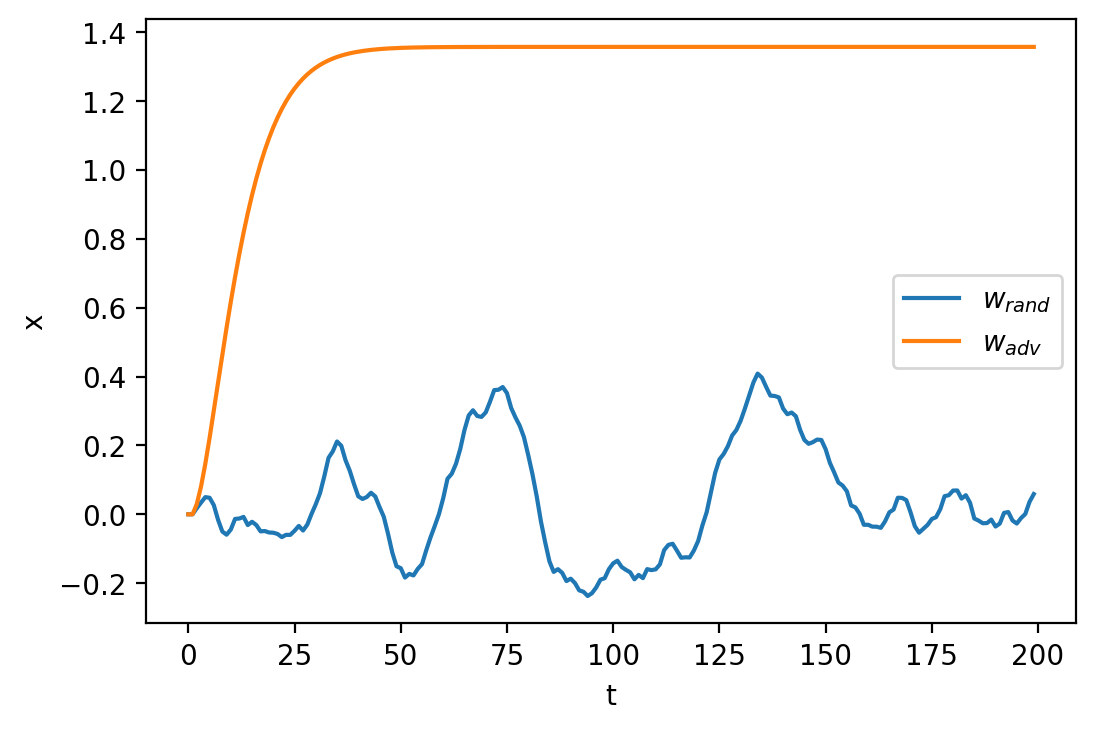

In [3]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.3
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

## Record the true system matrix for our later use

In [4]:

A = env.A
B = env.B


# Data collection

In [6]:
# for adv_disturbance in [0,1]:
#     for eta_bar in [0.1,0.5,1.0,1.5,2.0]: # The magnitude of exploration noise.
for adv_disturbance in [0,1]:
    for eta_bar in [0.1,0.5,1.0,2.0,4.0,10.0,20.0,40.0,60.0,80.0,100.0]: # The magnitude of exploration noise.
#     for eta_bar in [60.0,80.0]: # The magnitude of exploration noise.

        # Find a region(B(A,eps_init)) around A and ensure it contains only stable matrices.
        eps_init = find_stable_radius(A)

        est = ModelEstV2(A,B,eps_init) # The model estimator.

        H = 20 # Look back length

        # Constants
        x_dim = A.shape[-1]
        u_dim = B.shape[-1]

        I_x = np.eye(x_dim)  
        I_u = np.eye(u_dim)  


        w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

        # Optimaization Problem Parameters

        Q = np.array([[1,0],
                        [0,1]])*1
        R = np.eye(u_dim)*1

        D_x = np.vstack([I_x,-I_x]) # Constraints
        # d_x = np.array([0.5,0.5,0.5,0.5])
        d_x = np.array([4,6.0,4,6.0])

        D_u = np.vstack([I_u,-I_u])
        d_u = np.array([6,6])

        w_max = env.w_max 

        M0 = np.zeros((H,u_dim,x_dim))

        e_x = 0 # Usually e_x is not zero 
        e_u = 0 # For safe DAP with known B, e_u = 0

        refit_per_step = 50
        pre_run_steps = 2
        TD_steps  = 30 # The least number of steps taken in Phase 1.


        params = {'Q':Q,'R':R,'D_x':D_x,'d_x':d_x,'D_u':D_u,'d_u':d_u,'A':A,'B':B,'H':H,'eta_bar':eta_bar}
        with open('./data/Parameters.pkl','wb') as f:
            pkl.dump(params,f)

        def PureExploration(timesteps):
            # Data containers

            x_hist = []
            u_hist = []
            w_hat_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

            theta_hist = []
            refit_time_step = []
            phase1_endpoints =[]
            phase2_endpoints=[]
            M_hist = [M0]
            r_hist = []

            n_episode = 0

            env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=adv_disturbance)

            safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

            try:
            # main loop
                while True:
                    if n_episode>timesteps:
                        raise TimeStepsReached

                    x = env.state()
                    x_hist.append(x)
                    u = (np.random.rand()-0.5)*2*eta_bar
                    env.step(u)
                    u_hist.append(u)

                    if n_episode>0  and n_episode%refit_per_step == 0:
                        # Refit the system model
                        A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
                        theta_hist.append((np.array(A_hat),np.array(B_hat)))
                        r_hist.append(float(r))

                        print('Episode',n_episode)

                    n_episode+=1

            except TimeStepsReached:
                print('Time Steps Reached')
                # Prepare data output
                data = {}
                data['x'] = x_hist
                data['u'] = u_hist
                data['theta'] = theta_hist
                data['w'] = w_hat_hist
                return data


        alg_dict = {'PureExploration':PureExploration}

        n_trials = 10
        time_steps = 400
        for key, alg in alg_dict.items():
            print("{} starts.".format(key))
            trial_data = []
            for _ in range(n_trials):
                print('Trial {}'.format(_))
                trial_data.append(alg(time_steps))

            with open('./data/{}_eta_{}_adv_{}.pkl'.format(key,eta_bar,adv_disturbance),'wb') as f:
                pkl.dump(trial_data,f)

0.9697711780508523
PureExploration starts.
Trial 0
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 1
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 2
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 3
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 4
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 5
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 6
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
Time Steps Reached
Trial 7
Episode 50
Episode 100
Episode 150
Episode 200
Episode 250
Episode 300
Episode 350
Episode 400
